In [5]:
# ==============================================================
# 1. Install & Import Libraries
# ==============================================================i
import os, zipfile, shutil, random
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# ==============================================================
# Set Custom Dataset Download Location
# ==============================================================

os.environ["KAGGLEHUB_CACHE"] = "/Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01"   # custom path

# Download PlantVillage dataset
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Dataset downloaded to:", path)

# Extract dataset
zip_path = os.path.join(path, "plantvillage.zip")
extract_dir = "/Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/datasets/emmarex/plantdisease/versions/1/PlantVillage"
os.makedirs(extract_dir, exist_ok=True)

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset extracted to:", extract_dir)
else:
    print("Dataset already extracted:", path)

Dataset downloaded to: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/datasets/emmarex/plantdisease/versions/1
Dataset already extracted: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/datasets/emmarex/plantdisease/versions/1


In [7]:
# ==============================================================
# Auto Split into Train / Val / Test
# ==============================================================

source_dir = os.path.join(extract_dir, "PlantVillage")  # dataset root
train_dir = "data/train"
val_dir   = "data/val"
test_dir  = "data/test"

for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

train_split = 0.7
val_split   = 0.2
test_split  = 0.1

for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path): 
        continue
    
    images = os.listdir(cls_path)
    random.shuffle(images)
    total = len(images)
    
    train_count = int(total * train_split)
    val_count   = int(total * val_split)
    
    splits = {
        train_dir: images[:train_count],
        val_dir:   images[train_count:train_count+val_count],
        test_dir:  images[train_count+val_count:]
    }
    
    for split_dir, split_files in splits.items():
        split_cls_path = os.path.join(split_dir, cls)
        os.makedirs(split_cls_path, exist_ok=True)
        for f in split_files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(split_cls_path, f))

print("Data split into train/val/test.")


Data split into train/val/test.


In [8]:
# ==============================================================
# 4. Data Generators
# ==============================================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)

# Save class indices to JSON file
import json
os.makedirs("models", exist_ok=True)
with open("models/class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)
print("Class indices saved to: models/class_indices.json")

Found 14440 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
Class indices saved to: models/class_indices.json


In [9]:

# ==============================================================
# Class Weights
# ==============================================================

y_train = train_gen.classes
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.3811573409851745, 1: 0.9310122501611864, 2: 1.3752380952380951, 3: 1.3752380952380951, 4: 9.081761006289309, 5: 0.6469534050179212, 6: 1.3752380952380951, 7: 0.720558882235529, 8: 1.4454454454454455, 9: 0.77697067527576, 10: 0.8206876953680022, 11: 0.9803122878479293, 12: 0.4288047512991834, 13: 3.6883780332056193, 14: 0.8649296196466008}


In [10]:
# ==============================================================
# Model 1: CNN with L2 + BatchNorm
# ==============================================================

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-28 01:40:13.379941: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-28 01:40:13.381149: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-28 01:40:13.381174: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-28 01:40:13.381402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-28 01:40:13.381419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

In [11]:
# ==============================================================
# Model 2: MobileNetV2
# ==============================================================

base_mobilenet = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                             include_top=False, weights="imagenet")
base_mobilenet.trainable = False

x = layers.GlobalAveragePooling2D()(base_mobilenet.output)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

mobilenet_model = models.Model(base_mobilenet.input, output)
mobilenet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
# ==============================================================
# Model 3: ResNet50
# ==============================================================

base_resnet = ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                       include_top=False, weights="imagenet")
base_resnet.trainable = False

z = layers.GlobalAveragePooling2D()(base_resnet.output)
z = layers.Dense(512, activation="relu")(z)
z = layers.Dropout(0.5)(z)
output_resnet = layers.Dense(num_classes, activation="softmax")(z)

resnet_model = models.Model(base_resnet.input, output_resnet)
resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("✅ ResNet50 model created and compiled successfully!")

✅ ResNet50 model created and compiled successfully!


In [13]:
# ==============================================================
# Training
# ==============================================================

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

EPOCHS = 20

history_cnn = cnn_model.fit(train_gen, validation_data=val_gen,
                            epochs=EPOCHS, callbacks=callbacks,
                            class_weight=class_weights)

history_mobilenet = mobilenet_model.fit(train_gen, validation_data=val_gen,
                                        epochs=EPOCHS, callbacks=callbacks,
                                        class_weight=class_weights)

history_resnet = resnet_model.fit(train_gen, validation_data=val_gen,
                                  epochs=EPOCHS, callbacks=callbacks,
                                  class_weight=class_weights)

# Fine-tune ResNet50
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss="categorical_crossentropy", metrics=["accuracy"])

history_finetune = resnet_model.fit(train_gen, validation_data=val_gen,
                                    epochs=20, callbacks=callbacks,
                                    class_weight=class_weights)


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-09-28 01:40:18.069598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


452/452 ━━━━━━━━━━━━━━━━━━━━ 222s 485ms/step - accuracy: 0.3053 - loss: 130.5295 - val_accuracy: 0.3855 - val_loss: 135.5407 - learning_rate: 0.0010
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 226s 500ms/step - accuracy: 0.4117 - loss: 131.1966 - val_accuracy: 0.2618 - val_loss: 207.7341 - learning_rate: 0.0010
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 228s 505ms/step - accuracy: 0.4678 - loss: 96.1197 - val_accuracy: 0.3683 - val_loss: 145.1956 - learning_rate: 0.0010
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 254s 562ms/step - accuracy: 0.4762 - loss: 71.7334 - val_accuracy: 0.5934 - val_loss: 60.6225 - learning_rate: 0.0010
Epoch 5/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 264s 583ms/step - accuracy: 0.5017 - loss: 52.2141 - val_accuracy: 0.4981 - val_loss: 48.8428 - learning_rate: 0.0010
Epoch 6/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 322s 712ms/step - accuracy: 0.5377 - loss: 37.6839 - val_accuracy: 0.5616 - val_loss: 33.9666 - learning_rate: 0.0010
Epoch 7/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 345s 763ms/step - 


=== CNN + L2 + BN Evaluation ===
Accuracy: 0.7828
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.79      0.87      0.83       101
                     Pepper__bell___healthy       0.88      0.95      0.91       149
                      Potato___Early_blight       0.48      0.95      0.64       100
                       Potato___Late_blight       0.66      0.89      0.76       100
                           Potato___healthy       0.54      0.94      0.68        16
                      Tomato_Bacterial_spot       0.94      0.94      0.94       214
                        Tomato_Early_blight       0.53      0.77      0.63       100
                         Tomato_Late_blight       1.00      0.41      0.58       192
                           Tomato_Leaf_Mold       0.94      0.33      0.49        96
                  Tomato_Septoria_leaf_spot       0.72    

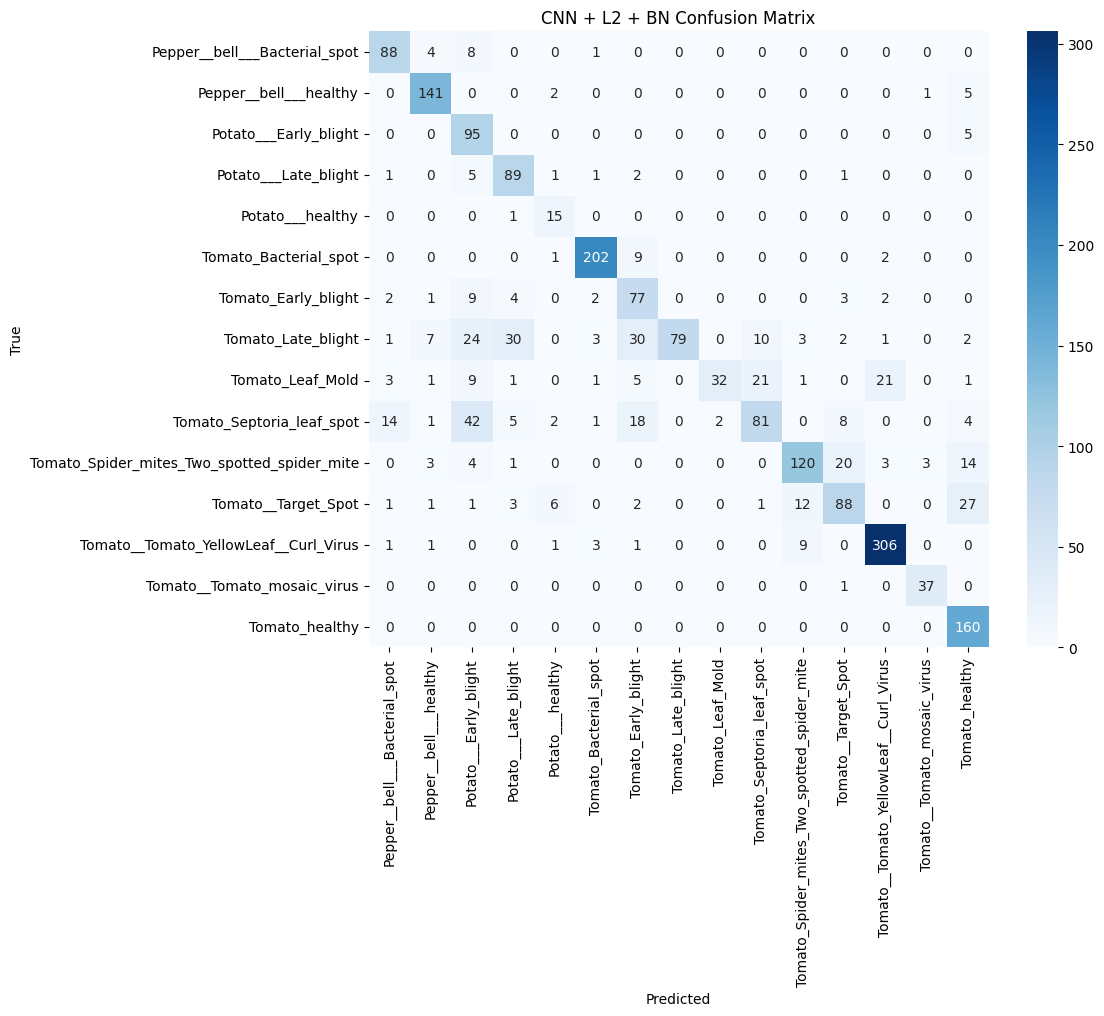


=== MobileNetV2 Evaluation ===
Accuracy: 0.8868
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.85      0.99      0.92       101
                     Pepper__bell___healthy       0.99      0.94      0.96       149
                      Potato___Early_blight       1.00      0.96      0.98       100
                       Potato___Late_blight       0.97      0.87      0.92       100
                           Potato___healthy       0.80      1.00      0.89        16
                      Tomato_Bacterial_spot       0.89      0.93      0.91       214
                        Tomato_Early_blight       0.81      0.59      0.68       100
                         Tomato_Late_blight       0.89      0.91      0.90       192
                           Tomato_Leaf_Mold       0.63      0.98      0.76        96
                  Tomato_Septoria_leaf_spot       0.85    

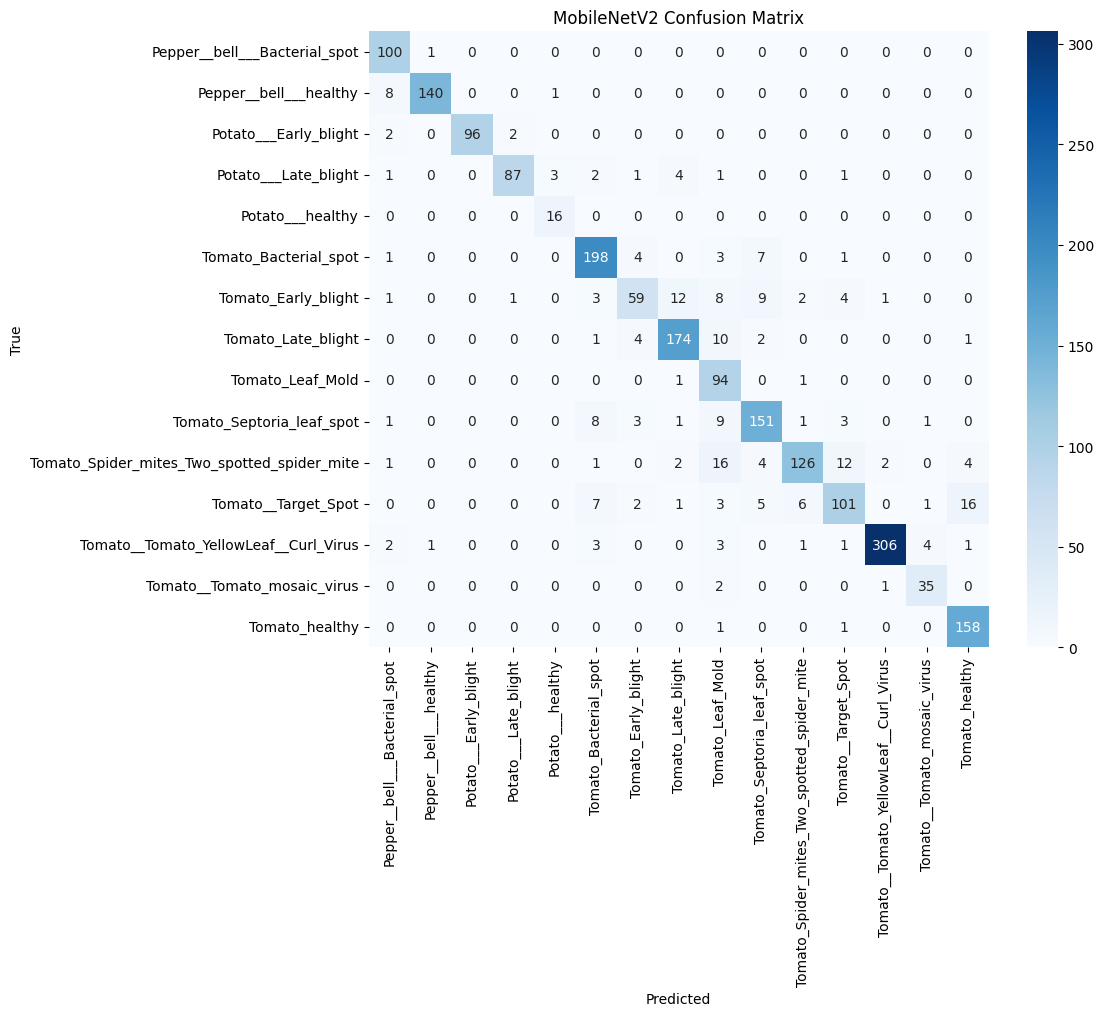


=== ResNet50 (Fine-tuned) Evaluation ===
Accuracy: 0.3719
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 450ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.25      0.49      0.33       101
                     Pepper__bell___healthy       0.47      0.64      0.54       149
                      Potato___Early_blight       0.25      0.51      0.34       100
                       Potato___Late_blight       0.18      0.02      0.04       100
                           Potato___healthy       0.06      0.81      0.11        16
                      Tomato_Bacterial_spot       0.59      0.68      0.63       214
                        Tomato_Early_blight       0.07      0.01      0.02       100
                         Tomato_Late_blight       0.80      0.02      0.04       192
                           Tomato_Leaf_Mold       0.03      0.02      0.03        96
                  Tomato_Septoria_leaf_spot     

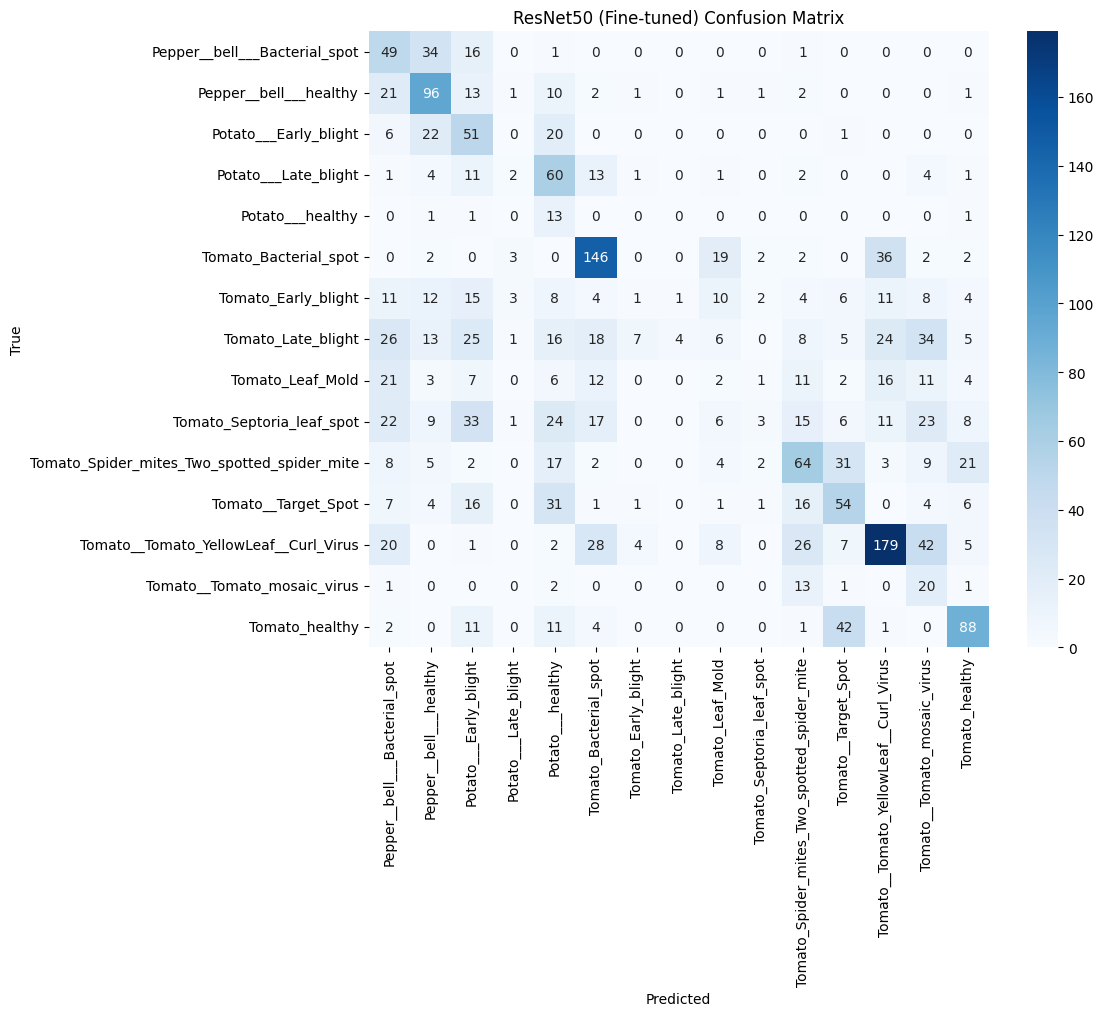

✅ All models saved inside /models folder


In [14]:
# ==============================================================
# Evaluation
# ==============================================================

def evaluate_model(model, data_gen, label="Model"):
    print(f"\n=== {label} Evaluation ===")
    val_loss, val_acc = model.evaluate(data_gen, verbose=0)
    print(f"Accuracy: {val_acc:.4f}")

    y_true = data_gen.classes
    y_pred = np.argmax(model.predict(data_gen), axis=1)

    print(classification_report(y_true, y_pred, target_names=list(data_gen.class_indices.keys())))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=data_gen.class_indices.keys(),
                yticklabels=data_gen.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{label} Confusion Matrix")
    plt.show()

evaluate_model(cnn_model, test_gen, "CNN + L2 + BN")
evaluate_model(mobilenet_model, test_gen, "MobileNetV2")
evaluate_model(resnet_model, test_gen, "ResNet50 (Fine-tuned)")

# Save CNN model
cnn_model.save("models/cnn_model.h5")

# Save MobileNetV2 model
mobilenet_model.save("models/mobilenet_model.h5")

# Save ResNet50 model (fine-tuned)
resnet_model.save("models/resnet_model.h5")

print("✅ All models saved inside /models folder")